In [1]:
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from network_funcs import add_relation_column, create_question_df

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
random.seed(42)

In [2]:
df = pd.read_excel("../data/sociogram_corrected.xlsx").dropna()
df["classroom"] = df["classroom"].astype(int)
periods = pd.read_excel("../data/classroom_ids.xlsx").rename(columns = {"classroom_session_id":"classroom"})[["classroom", "period"]]
genders = pd.read_excel("../data/genders.xlsx").rename(columns = {"genere":"gender"}).loc[:, ["student", "gender"]]
tt = periods.merge(df).merge(genders)
cog_dists = pd.read_excel("../data/cog_distances.xlsx")
cog_group = pd.read_csv("../output/theta.csv")

In [3]:
# Average the cognitive distances of pairs of students happening more than once
cog_dists = cog_dists.groupby(["classroom_session_id", "student_id", "id"]).mean("dist").reset_index()

In [4]:
all = cog_dists
all = add_relation_column(all, create_question_df(tt, "work_yes"), "work_yes")
all = add_relation_column(all, create_question_df(tt, "work_no"), "work_no")
all = add_relation_column(all, create_question_df(tt, "play_yes"), "play_yes")
all = add_relation_column(all, create_question_df(tt, "play_no"), "play_no")
all = add_relation_column(all, create_question_df(tt, "friend"), "friend")

# add gender to the dataframe

In [5]:
all_w_period = all.merge(periods, left_on="classroom_session_id", right_on="classroom").drop(columns=["classroom"])
all_w_genders = all_w_period.merge(
    genders, left_on="student_id", right_on="student"
).merge(
    genders, left_on="id", right_on="student", suffixes=("_student", "_id")
)

In [6]:
all_w_genders["same_gender"] = np.where(all_w_genders["gender_student"] == all_w_genders["gender_id"], "Yes", "No")

In [7]:
df = all_w_genders.drop_duplicates().drop(["good", "bad", "student_id"], axis=1)
df["period"] = df["period"] - 4

In [8]:
df.gender_student.value_counts()

Nen            45840
Nena           40520
Altre          15256
No contesta      788
Name: gender_student, dtype: int64

In [9]:
df

,classroom_session_id,id,dist,work_yes,work_no,play_yes,play_no,friend,period,student_student,gender_student,gender_id,same_gender
0,1,1627,0.228657,0,0,0,0,0,2,1626,Nena,Nena,Yes
25,1,1627,0.146230,0,0,0,0,0,2,1628,Nena,Nena,Yes
50,1,1627,0.402544,0,0,0,0,0,2,1629,Nen,Nena,No
75,1,1627,0.125585,0,0,0,0,0,2,1630,Nen,Nena,No
100,1,1627,0.287401,0,0,1,0,1,2,1631,Nena,Nena,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3476514,247,6924,0.187329,0,0,0,0,0,7,6941,Nen,Nena,No
3476800,247,6924,0.335719,0,0,0,0,0,7,6942,Nena,Nena,Yes
3477086,247,6924,0.386866,0,0,0,0,0,7,6943,Nen,Nena,No
3477372,247,6924,0.228776,0,0,1,0,1,7,6944,Nena,Nena,Yes


In [12]:
# fitler for only "Nen" and "Nena"
df = df[df["gender_student"].isin(["Nen", "Nena"])]
# rename columns
df = df.rename(columns={"work_yes": "Working with", "work_no": "Not working with", "play_yes": "Playing with", "play_no": "Not playing with", "friend": "Friends"})

interaction_types = ['Working with', 'Not working with', 'Playing with', 'Not playing with', 'Friends']

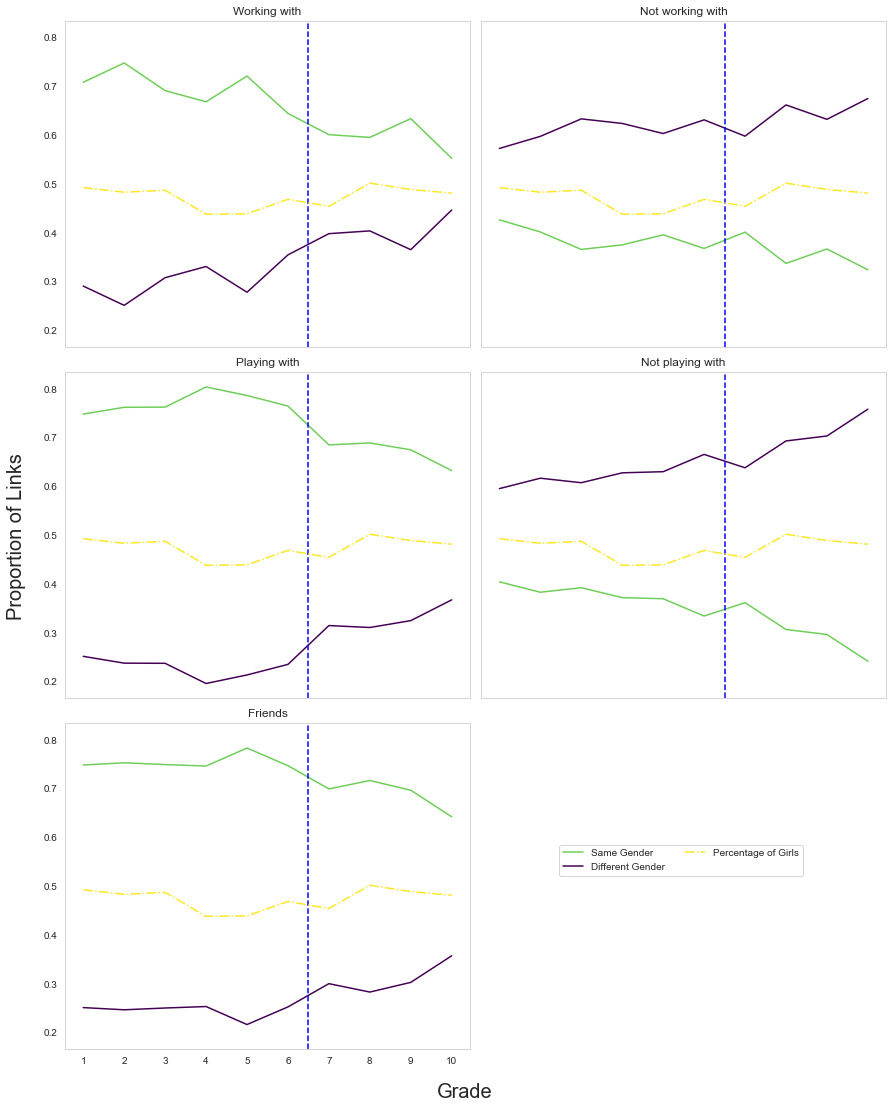

In [14]:
# Calculate the proportions of same-gender and different-gender links for each interaction type
gender_plot_data = {}
girls_percentage = df[df['gender_student'] == 'Nena'].groupby('period')['student_student'].nunique() / df.groupby('period')['student_student'].nunique()
boys_percentage = df[df['gender_student'] == 'Nen'].groupby('period')['student_student'].nunique() / df.groupby('period')['student_student'].nunique()
others_percentage = df[df['gender_student'] == 'Altre'].groupby('period')['student_student'].nunique() / df.groupby('period')['student_student'].nunique()

yellow = "#fde725"
purple = "#440154"
blue_green = "#21918c"
green = "#6ece58"
blue_gray = "#3b528b"
soft_green = "#9ac64d"
dark_green = "#35b779"
colours = [green, purple, yellow, blue_gray, blue_green, soft_green, dark_green]


for interaction in interaction_types:
    # For same-gender links
    same_gender = df[(df[interaction] == 1) & (df['same_gender'] == 'Yes')].groupby('period').size()
    # For different-gender links
    diff_gender = df[(df[interaction] == 1) & (df['same_gender'] == 'No')].groupby('period').size()
    # Total number of links per grade for normalization
    total_links = df[df[interaction] == 1].groupby('period').size()
    
    # Calculate proportions
    same_gender_prop = same_gender / total_links
    diff_gender_prop = diff_gender / total_links
    
    # Store in the plot data dictionary
    gender_plot_data[interaction] = (same_gender_prop, diff_gender_prop)

# Plotting the updated data with the requested refinements
fig, axs = plt.subplots(3, 2, figsize=(12, 15), sharex=True, sharey=True)  # Create a grid of subplots with shared axes

# Remove the last (empty) subplot
fig.delaxes(axs[2][1])

# Plot each interaction type
for ax, (interaction, (same_gender_prop, diff_gender_prop)) in zip(axs.flat, gender_plot_data.items()):
    # Plot using the viridis color scale
    ax.plot(same_gender_prop.index, same_gender_prop.values, label='Same Gender', color=colours[0])
    ax.plot(diff_gender_prop.index, diff_gender_prop.values, label='Different Gender', color=colours[1])
    ax.axvline(6.5, color='blue', linestyle='--')
    ax.plot(girls_percentage.index, girls_percentage.values, label='Percentage of Girls', color=colours[2], linestyle='-.')
  #  ax.plot(boys_percentage.index, boys_percentage.values, label='Percentage of Boys', color=colours[3], linestyle='-.')
 #   ax.plot(others_percentage.index, others_percentage.values, label='Percentage answering "Other"', color=colours[4], linestyle='-.')
    ax.set_title(interaction.replace('_', ' ').capitalize())
    ax.set_xticks(range(1, 11))  # Show all grades on the x-axis
    ax.grid(False)

# Set a common y-axis label
fig.text(-0.03, 0.5, 'Proportion of Links', va='center', rotation='vertical', fontsize=20)
fig.text(0.5, -0.02, 'Grade', ha='center', fontsize=20)


# Place the color legend only in the "Friend" plot
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.75, .2), ncol=2)

plt.tight_layout()
plt.show()

# Save the figure
fig.savefig("../plots/gender_choice_percentages_only_nen_nena.pdf", dpi=300, bbox_inches="tight")

In [15]:
df

In [16]:
df